In [ ]:
import sys
from pathlib import Path

# Get the absolute path to the base directory (one level up from notebook dir)
BASE_DIR = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent

# Add to sys.path if not already present
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# Now you can import directly
from zeromodel import ZeroModel


c:\Users\ernan\Project\zeromodel\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
2025-08-11 19:38:18,456 - zeromodel.core - DEBUG - Initializing ZeroModel with metrics: ['uncertainty', 'margin', 'disagreement', 'novelty', 'energy', 'inv_conf'], config: {'use_duckdb': False, 'duckdb_bypass_threshold': 0.5, 'precision': 8, 'normalize_inputs': True, 'nonlinearity_handling': 'auto', 'cache_preprocessed_vpm': True, 'max_cached_tasks': 100, 'default_output_precision': 'float32'}
2025-08-11 19:38:18,466 - zeromodel.duckdb_adapter - DEBUG - DuckDB virtual_index table created with 6 metrics.
2025-08-11 19:38:18,467 - zeromodel.normalizer - DEBUG - Initializing DynamicNormalizer for 6 metrics
2025-08-11 19:38:18,468 - zeromodel.normalizer - INFO - Normalizer initialized with alph

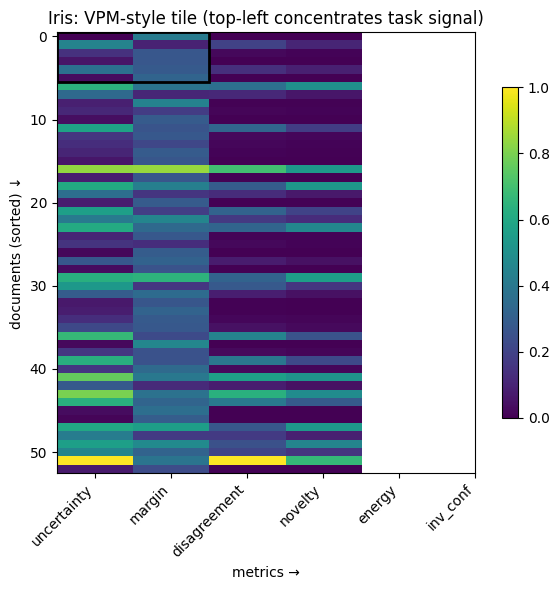

In [11]:
# ZeroModel Visual AI demo with offline datasets
# Works fully offline with scikit-learn. If zeromodel is importable, uses it;
# otherwise builds a mock VPM so you can still see the top-left concentration.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

# ---- choose dataset: "iris" | "wine" | "cancer" | "xor"
DATASET = "iris"

# ---- load data
if DATASET == "iris":
    ds = load_iris()
    X, y = ds.data, ds.target
    name = "Iris"
elif DATASET == "wine":
    ds = load_wine()
    X, y = ds.data, ds.target
    name = "Wine"
elif DATASET == "cancer":
    ds = load_breast_cancer()
    X, y = ds.data, ds.target
    name = "Breast Cancer"
elif DATASET == "xor":
    # hard nonlinear: 2 informative features laid out XOR-like
    X, y = make_classification(n_samples=1000, n_features=10, n_informative=2, 
                               n_redundant=0, n_clusters_per_class=1, class_sep=1.0, random_state=7)
    name = "Synthetic XOR"
else:
    raise ValueError("Unknown DATASET")

# ---- split & scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, stratify=y)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# ---- two simple models so we can measure uncertainty & disagreement
clf1 = LogisticRegression(max_iter=500, multi_class="auto", solver="lbfgs", n_jobs=None).fit(X_train_s, y_train)
clf2 = RandomForestClassifier(n_estimators=200, random_state=0).fit(X_train_s, y_train)

proba1 = clf1.predict_proba(X_test_s)
proba2 = clf2.predict_proba(X_test_s)

# ---- per-sample metrics in [0,1] for a VPM "documents x metrics"
# 1) Uncertainty: 1 - confidence (max prob) from model 1
uncertainty = 1.0 - proba1.max(axis=1)

# 2) Margin: difference between top-1 and top-2 probs (smaller = harder)
def top2_margin(P):
    sortp = np.sort(P, axis=1)
    return (sortp[:, -1] - sortp[:, -2]) if P.shape[1] >= 2 else sortp[:, -1]
margin = 1.0 - top2_margin(proba1)  # invert so "higher = more interesting"

# 3) Disagreement: Jensen-Shannon-ish divergence proxy between models (cheap)
eps = 1e-12
P = np.clip(proba1, eps, 1.0); Q = np.clip(proba2, eps, 1.0)
M = 0.5*(P+Q)
kl = (P*np.log(P/M)).sum(axis=1) + (Q*np.log(Q/M)).sum(axis=1)
disagreement = (kl - kl.min()) / (np.ptp(kl) + 1e-12)

# 4) Novelty: distance to nearest training neighbor (higher = more novel)
nn = NearestNeighbors(n_neighbors=1).fit(X_train_s)
dists, _ = nn.kneighbors(X_test_s, n_neighbors=1)
novelty = (dists[:,0] - dists.min()) / (np.ptp(dists) + 1e-12)

# 5) Feature energy: L2 norm (scaled), acts like a “size/strength” proxy
energy = np.linalg.norm(X_test_s, axis=1)
energy = (energy - energy.min())/(np.ptp(energy) + 1e-12)

# 6) Ensemble confidence (max prob from averaged probs), invert for “interesting”
proba_avg = 0.5*(proba1 + proba2)
conf_inv = 1.0 - proba_avg.max(axis=1)

# stack metrics (N_docs x N_metrics)
metric_names = ["uncertainty","margin","disagreement","novelty","energy","inv_conf"]
S = np.vstack([uncertainty, margin, disagreement, novelty, energy, conf_inv]).T  # shape (N,6)

# safe clip
S = np.clip(S, 0.0, 1.0)


def make_and_show_vpm(S, metric_names, title, task_sql=None, nonlinearity_hint="auto"):
    zm = ZeroModel(metric_names=metric_names)
    if task_sql is None:
        # push AI-ish/uncertain items to top-left by default
        task_sql = """
        SELECT * FROM virtual_index
        ORDER BY uncertainty DESC, margin DESC, disagreement DESC, novelty DESC
        """
    zm.prepare(S, task_sql, nonlinearity_hint=nonlinearity_hint)
    vpm = zm.encode()  # (rows, width_pixels, 3)
    # visualize R channel approx by summing RGB
    img = vpm.sum(axis=2).astype(np.float32)
    img = (img - img.min()) / (np.ptp(img) + 1e-9)

    # plot
    plt.figure(figsize=(6,6))
    plt.imshow(img, aspect='auto', origin='upper', interpolation='nearest')
    plt.title(title)
    plt.xlabel("metrics →")
    plt.ylabel("documents (sorted) ↓")
    # add metric ticks if not too many
    if img.shape[1] <= 12:
        plt.xticks(range(len(metric_names)), metric_names, rotation=45, ha='right')
    else:
        plt.xticks([])
    # draw a box around the top-left “critical” patch
    h = min(6, img.shape[0]-1)
    w = min(2, img.shape[1]-1)
    plt.gca().add_patch(plt.Rectangle((-.5, -.5), w, h, fill=False, linewidth=2))
    plt.colorbar(shrink=0.75)
    plt.tight_layout()
    plt.show()
    return img

title = f"{name}: VPM-style tile (top-left concentrates task signal)"
_ = make_and_show_vpm(S, metric_names, title)
